In [ ]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten, Embedding, Reshape
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm
import plotly.express as px

plt.rcParams['font.size'] =  12

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

 98% 1.73G/1.76G [00:09<00:00, 277MB/s]
100% 1.76G/1.76G [00:09<00:00, 194MB/s]


In [ ]:

!unzip "/content/drive/MyDrive/Dataset Kanker paru dan usus besar/lung_colon_image_set_greyscale.zip"


Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: lung_colon_image_set_greyscale/lung_image_sets/lung_scc/Lung_SCC_0001.jpg  
  inflating: lung_colon_image_set_greyscale/lung_image_sets/lung_scc/Lung_SCC_0002.jpg  
  inflating: lung_colon_image_set_greyscale/lung_image_sets/lung_scc/Lung_SCC_0003.jpg  
  inflating: lung_colon_image_set_greyscale/lung_image_sets/lung_scc/Lung_SCC_0004.jpg  
  inflating: lung_colon_image_set_greyscale/lung_image_sets/lung_scc/Lung_SCC_0005.jpg  
  inflating: lung_colon_image_set_greyscale/lung_image_sets/lung_scc/Lung_SCC_0006.jpg  
  inflating: lung_colon_image_set_greyscale/lung_image_sets/lung_scc/Lung_SCC_0007.jpg  
  inflating: lung_colon_image_set_greyscale/lung_image_sets/lung_scc/Lung_SCC_0008.jpg  
  inflating: lung_colon_image_set_greyscale/lung_image_sets/lung_scc/Lung_SCC_0009.jpg  
  inflating: lung_colon_image_set_greyscale/lung_image_sets/lung_scc/Lung_SCC_0010.jpg  
  inflating: lung_colon_image_set_greyscale/lung_im

In [ ]:
!mkdir ./LungColon

print('Copying files...')
!cp -R /content/lung_colon_image_set_greyscale/colon_image_sets/* ./LungColon
!cp -R /content/lung_colon_image_set_greyscale/lung_image_sets/* ./LungColon
print('All files copied successfully!')

Copying files...
All files copied successfully!


In [ ]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

splitfolders.ratio('/content/LungColon', '/content/parudanusus', seed=1, ratio=(.8, .2))

Copying files: 25000 files [00:05, 4277.00 files/s]


In [ ]:
import splitfolders

splitfolders.ratio('/content/parudanusus/val', '/content/parudanusus/Testing', seed=1, ratio=(.9, .1))

Copying files: 5000 files [00:00, 7319.24 files/s]


In [ ]:
!mv parudanusus "/content/drive/MyDrive/Dataset Kanker paru dan usus besar"

In [ ]:
train_dir = '/content/drive/MyDrive/Dataset Kanker paru dan usus besar/parudanusus/train'
test_dir = '/content/drive/MyDrive/Dataset Kanker paru dan usus besar/parudanusus/Testing/Testing'

In [ ]:
training_data = []
test_data = []
labels = os.listdir(train_dir)
for folder in os.listdir(train_dir):
    training_data.append(len(os.listdir(os.path.join(train_dir,folder))))
    
for folder in os.listdir(test_dir):
    test_data.append(len(os.listdir(os.path.join(test_dir,folder))))

In [ ]:
fig = px.bar(x=labels, y=training_data, title='Class Count Training Data')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

In [ ]:
fig = px.bar(x=labels, y=test_data, title='Class Count Test Data')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

In [ ]:
batch_size = 32
img_size = 224

datagen = ImageDataGenerator(rescale=1/255.,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = datagen.flow_from_directory(train_dir,  
                                                target_size=(img_size, img_size), 
                                                batch_size=batch_size,
                                                classes=['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],
                                                shuffle=True,
                                                subset='training',
                                                class_mode='categorical')  

validation_generator = datagen.flow_from_directory(train_dir,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    classes=['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],
                                                    shuffle=False,
                                                    subset='validation',
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=(img_size, img_size),
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 class_mode='categorical')

Found 16000 images belonging to 5 classes.
Found 4000 images belonging to 5 classes.
Found 4500 images belonging to 5 classes.


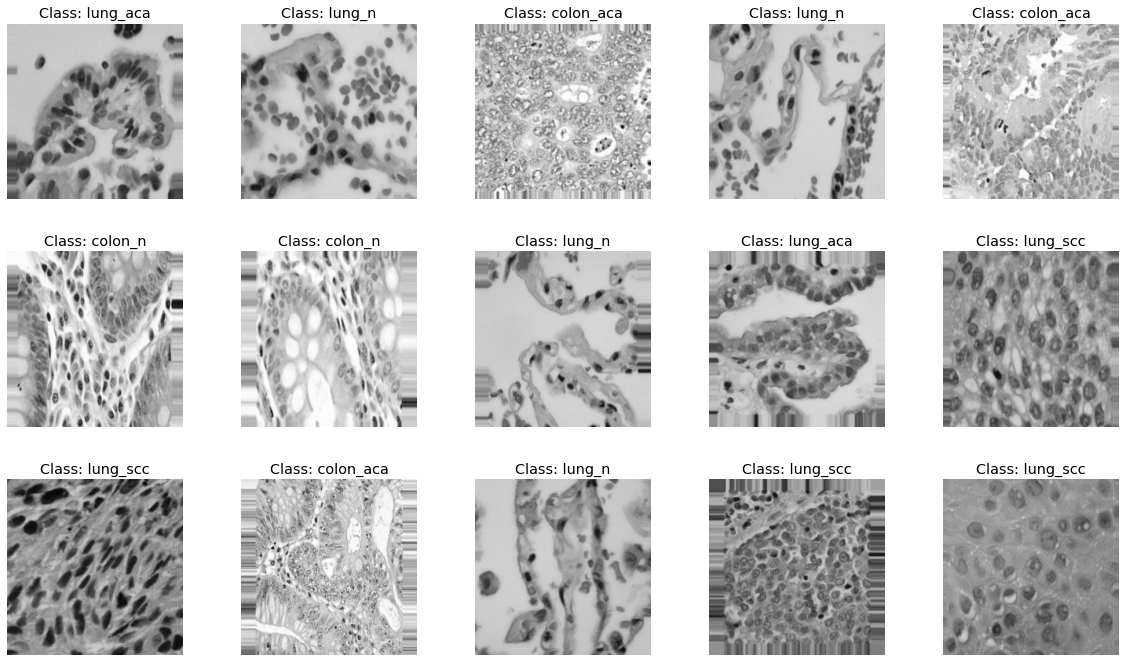

In [ ]:
labels = [k for k,v in train_generator.class_indices.items()]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

In [ ]:
from tensorflow.keras.applications import VGG19
img_size = 224
base_model = VGG19(include_top = False,
                       weights = 'imagenet',
                       input_shape = (img_size,img_size,3))

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
len(base_model.layers)

22

In [ ]:
base_model.layers

In [ ]:
freeze_index = None
for i,layer in enumerate(base_model.layers):
    if 'block4' in layer._name:
        freeze_index = i
        break
        
for layer in base_model.layers[:freeze_index]:
    layer.trainable = False

In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras import regularizers
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Flatten()(x)
#x = Dense(64, kernel_regularizer=regularizers.l2(0.0001), activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Dense(128, kernel_regularizer=regularizers.l2(0.0001), activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Dense(256, kernel_regularizer=regularizers.l2(0.0001), activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dense(5120, kernel_regularizer=regularizers.l2(0.0001), activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model_name = "model_Vgg19_Grayscale_Kanker(2).hdf5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.00000001)

In [ ]:
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/30
500/500 [==============================] - ETA: 0s - loss: 0.4142 - accuracy: 0.8687
Epoch 1: val_loss improved from inf to 0.37285, saving model to model_Vgg19_Grayscale_Kanker(2).hdf5
500/500 [==============================] - 304s 582ms/step - loss: 0.4142 - accuracy: 0.8687 - val_loss: 0.3728 - val_accuracy: 0.8823 - lr: 1.0000e-04
Epoch 2/30
500/500 [==============================] - ETA: 0s - loss: 0.2027 - accuracy: 0.9475
Epoch 2: val_loss improved from 0.37285 to 0.15949, saving model to model_Vgg19_Grayscale_Kanker(2).hdf5
500/500 [==============================] - 289s 578ms/step - loss: 0.2027 - accuracy: 0.9475 - val_loss: 0.1595 - val_accuracy: 0.9590 - lr: 1.0000e-04
Epoch 3/30
500/500 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 0.9623
Epoch 3: val_loss did not improve from 0.15949
500/500 [==============================] - 289s 577ms/step - loss: 0.1566 - accuracy: 0.9623 - val_loss: 0.1634 - val_accuracy: 0.9582 - lr: 1.0000e-04
Epo

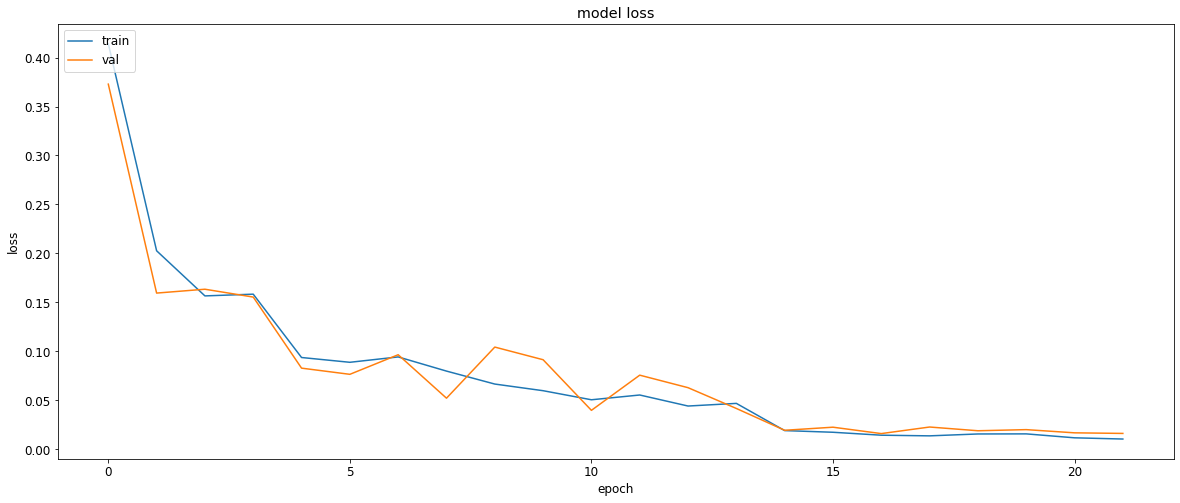

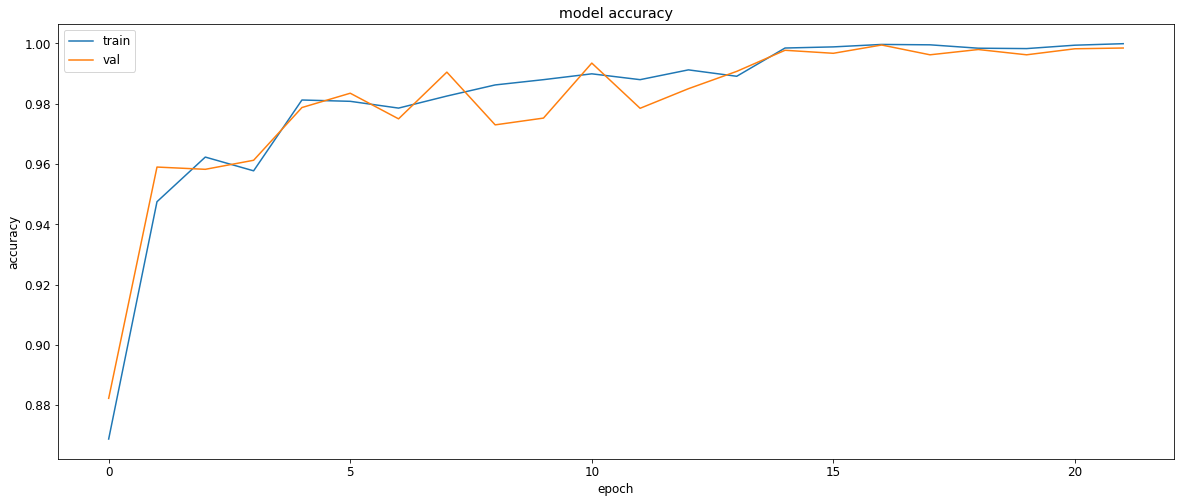

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_loss = model.evaluate(test_generator)

141/141 [==============================] - 31s 219ms/step - loss: 0.0193 - accuracy: 0.9982


In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.test_loss['loss'])
plt.title('loss overfitting test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_test = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred,axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_pred,target_names = labels))

              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00       900
     colon_n       1.00      1.00      1.00       900
    lung_aca       1.00      0.99      1.00       900
      lung_n       1.00      1.00      1.00       900
    lung_scc       0.99      1.00      1.00       900

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500



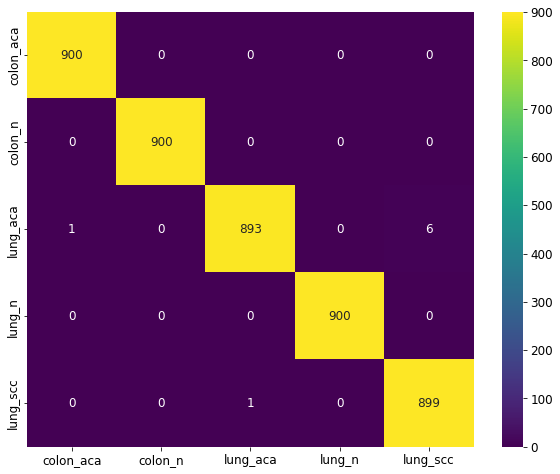

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=labels,yticklabels=labels,cmap='viridis')
plt.show()

Saving Lung_Aca_0043.jpg to Lung_Aca_0043.jpg


ValueError: ignored

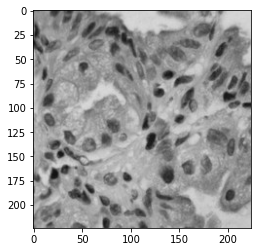

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)

  if classes[0]!=0:
    print('colon_aca')
  elif classes[1]!=0:
    print('colon_n')
  elif classes[2]!=0:
    print('lung_aca')
  elif classes[3]!=0:
    print('lung_n')
  else:
    print('lung_scc')